In [34]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# Preprocessing And Augmentation

In [40]:
# Define paths to your datasets
train_dir = '/kaggle/input/datasetf/dataF/train'
test_dir = '/kaggle/input/datasetf/dataF/test'

# Parameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 30

# Define the image size and batch size
image_size = 224  # Typical size for MobileNet, can be 224, 160, 128, etc.
batch_size = 32  # Adjust based on your memory constraints


In [41]:
# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split to 20%
)

# Rescaling for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Creating the training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Creating the validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Use same directory as training data
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

# Creating the test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 7116 images belonging to 3 classes.
Found 1778 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


# Handling imbalance 

In [42]:
# Get class labels
class_labels = train_generator.classes

# Encode the class labels as integers
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(class_labels)
print("Encoded labels:", integer_encoded_labels)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(integer_encoded_labels),
    y=integer_encoded_labels
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights)


Encoded labels: [0 0 0 ... 2 2 2]
Class weights: {0: 0.6753986332574032, 1: 3.2944444444444443, 2: 0.8224687933425797}


# CNN Model

In [46]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


input_shape = (img_height, img_width, 3)
cnn_model = create_cnn_model(input_shape)
cnn_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_model.keras', save_best_only=True)

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/30
  2/223 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.4609 - loss: 2.4533

W0000 00:00:1717130061.495719     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  6/223 ━━━━━━━━━━━━━━━━━━━━ 5:20 1s/step - accuracy: 0.3719 - loss: 4.3404

W0000 00:00:1717130068.760033     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.4717 - loss: 1.3483

W0000 00:00:1717130167.549871     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717130169.030771     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


223/223 ━━━━━━━━━━━━━━━━━━━━ 117s 496ms/step - accuracy: 0.4720 - loss: 1.3466 - val_accuracy: 0.5450 - val_loss: 0.8978
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 105s 456ms/step - accuracy: 0.6170 - loss: 0.7515 - val_accuracy: 0.6333 - val_loss: 1.0183
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 107s 466ms/step - accuracy: 0.6850 - loss: 0.6469 - val_accuracy: 0.7000 - val_loss: 0.8054
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 107s 467ms/step - accuracy: 0.7147 - loss: 0.6013 - val_accuracy: 0.6933 - val_loss: 0.7945
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 108s 469ms/step - accuracy: 0.7639 - loss: 0.5332 - val_accuracy: 0.7000 - val_loss: 0.7637
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 140s 463ms/step - accuracy: 0.7801 - loss: 0.5025 - val_accuracy: 0.7333 - val_loss: 0.7794
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 108s 469ms/step - accuracy: 0.7895 - loss: 0.4604 - val_accuracy: 0.7233 - val_loss: 0.7011
Epoch 8/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 105s 457ms/step - accuracy: 0.7918 - loss: 0.44

In [48]:
# Evaluate the model
loss, accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7749 - loss: 0.4970
Test Accuracy: 76.17%


# MobileNet Model

In [49]:
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = MobileNetV2(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Freeze all layers except the last few
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

mobilenet_model = create_mobilenet_model(input_shape)
mobilenet_model.summary()

# Train the MobileNet model
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the MobileNet model
loss_mobilenet, accuracy_mobilenet = mobilenet_model.evaluate(test_generator)
print(f"MobileNet Test Accuracy: {accuracy_mobilenet*100:.2f}%")


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30
  1/223 ━━━━━━━━━━━━━━━━━━━━ 47:40 13s/step - accuracy: 0.2812 - loss: 1.5713

W0000 00:00:1717132503.838598     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.7822 - loss: 0.5360

W0000 00:00:1717132610.867490     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717132613.440831     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


223/223 ━━━━━━━━━━━━━━━━━━━━ 123s 496ms/step - accuracy: 0.7827 - loss: 0.5348 - val_accuracy: 0.9300 - val_loss: 0.2419
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 108s 469ms/step - accuracy: 0.8928 - loss: 0.2554 - val_accuracy: 0.9300 - val_loss: 0.2047
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 107s 466ms/step - accuracy: 0.9040 - loss: 0.2354 - val_accuracy: 0.8750 - val_loss: 0.3289
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 107s 462ms/step - accuracy: 0.9133 - loss: 0.2348 - val_accuracy: 0.9117 - val_loss: 0.2401
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 107s 465ms/step - accuracy: 0.9132 - loss: 0.2147 - val_accuracy: 0.9100 - val_loss: 0.2585
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 106s 462ms/step - accuracy: 0.9186 - loss: 0.1957 - val_accuracy: 0.9067 - val_loss: 0.2296
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 107s 468ms/step - accuracy: 0.9314 - loss: 0.1645 - val_accuracy: 0.9333 - val_loss: 0.1925
Epoch 8/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 106s 462ms/step - accuracy: 0.9202 - loss: 0.18

# Fine-Tuning MobileNet

In [63]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the base MobileNetV2 model, excluding the top layers
base_model = MobileNetV2(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Freeze all layers except the last few layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Define the model architecture
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Adjust the number of classes if necessary
])

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpointing
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('fine_tuned_mobilenet.keras', save_best_only=True)
]

# Train the model
history_finetune = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=fine_tune_callbacks
)

# Evaluate the fine-tuned MobileNet model
loss_finetune, accuracy_finetune = mobilenet_model.evaluate(test_generator)
print(f"Fine-tuned MobileNet Test Accuracy: {accuracy_finetune*100:.2f}%")


Epoch 1/30
  1/223 ━━━━━━━━━━━━━━━━━━━━ 1:06:24 18s/step - accuracy: 0.4375 - loss: 1.9003

W0000 00:00:1717139526.748265     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/223 ━━━━━━━━━━━━━━━━━━━━ 50s 514ms/step - accuracy: 0.4423 - loss: 1.6915

W0000 00:00:1717139590.454157     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


222/223 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.4637 - loss: 1.6002

W0000 00:00:1717139637.395176     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717139664.870403     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


223/223 ━━━━━━━━━━━━━━━━━━━━ 157s 625ms/step - accuracy: 0.4641 - loss: 1.5986 - val_accuracy: 0.6609 - val_loss: 0.9564
Epoch 2/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 133s 584ms/step - accuracy: 0.6385 - loss: 1.0788 - val_accuracy: 0.7042 - val_loss: 0.9022
Epoch 3/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 132s 578ms/step - accuracy: 0.7437 - loss: 0.8616 - val_accuracy: 0.7441 - val_loss: 0.8324
Epoch 4/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 132s 577ms/step - accuracy: 0.7915 - loss: 0.7563 - val_accuracy: 0.7880 - val_loss: 0.7610
Epoch 5/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 132s 579ms/step - accuracy: 0.8220 - loss: 0.6740 - val_accuracy: 0.8251 - val_loss: 0.6946
Epoch 6/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 147s 643ms/step - accuracy: 0.8491 - loss: 0.6382 - val_accuracy: 0.8442 - val_loss: 0.6162
Epoch 7/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 133s 582ms/step - accuracy: 0.8664 - loss: 0.5716 - val_accuracy: 0.8611 - val_loss: 0.5864
Epoch 8/30
223/223 ━━━━━━━━━━━━━━━━━━━━ 132s 576ms/step - accuracy: 0.8771 - loss: 0.55

# Check Overfitting

In [57]:
import matplotlib.pyplot as plt

def plot_training_history(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


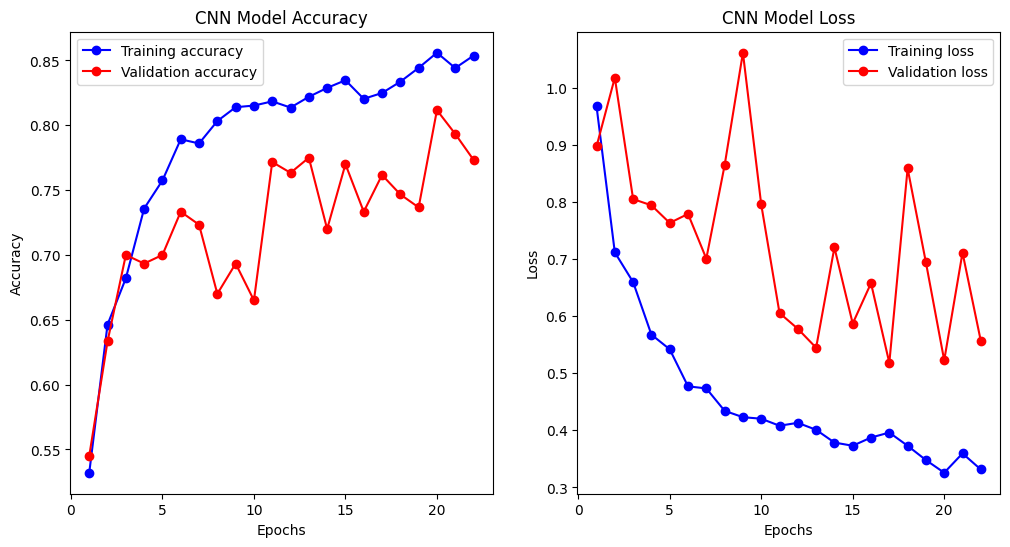

In [58]:


# Plot training history for the CNN model
plot_training_history(history, title='CNN Model')


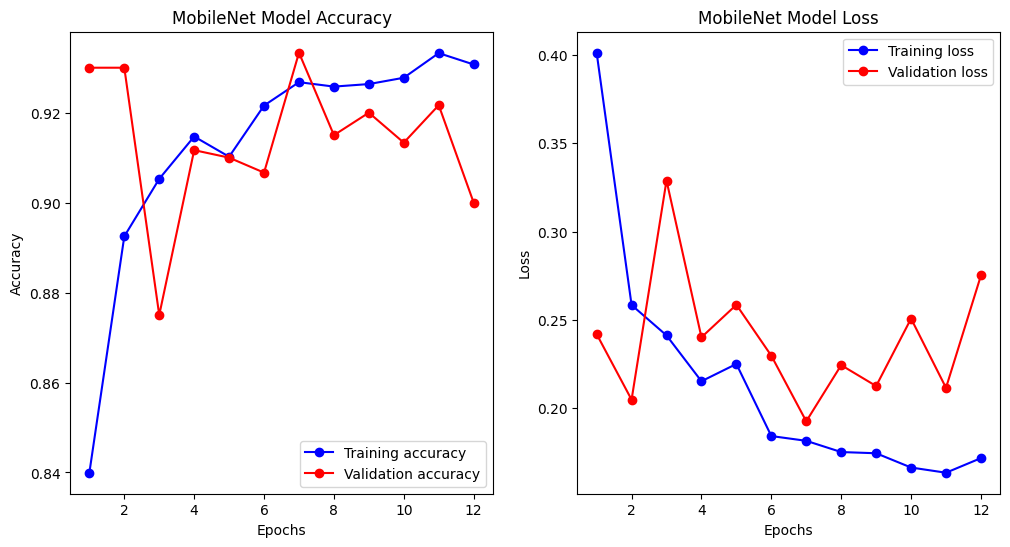

In [61]:

# Plot training history for the MobileNet model
plot_training_history(history_mobilenet, title='MobileNet Model')


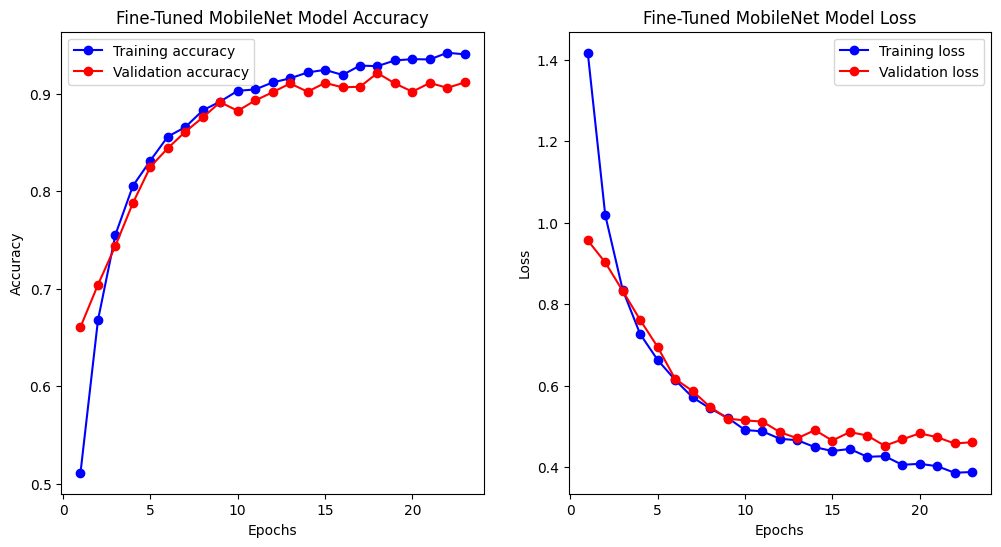

In [64]:
# Plot training history for the fine-tuned MobileNet model
plot_training_history(history_finetune, title='Fine-Tuned MobileNet Model')